In [1]:
import tensorflow as tf
# for displaying image
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%pylab inline
# for data operation
import pandas as pd
import numpy as np

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Populating the interactive namespace from numpy and matplotlib


# How to import data from tfrecord files using dataset API

* Author: YJango

* Tutorial: https://www.zhihu.com/people/YJango/posts 

# generate data


scalar
type:int64
shape: ()
example0
1
example1
2
example2
3

vector
type:float32
shape: (3,)
example0
[ 0.1  0.1  0.1]
example1
[ 0.2  0.2  0.2]
example2
[ 0.3  0.3  0.3]

matrix
type:float32
shape: (2, 3)
example0
[[ 0.1  0.1  0.1]
 [ 0.1  0.1  0.1]]
example1
[[ 0.2  0.2  0.2]
 [ 0.2  0.2  0.2]]
example2
[[ 0.3  0.3  0.3]
 [ 0.3  0.3  0.3]]

3D-tensor
type:uint8
shape: (806, 806, 3)


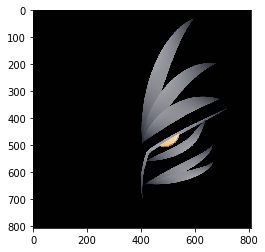

In [71]:
np.set_printoptions(precision=3)
# display function
def display(alist, show = True):
    print('type:%s\nshape: %s' %(alist[0].dtype,alist[0].shape))
    if show:
        for i in range(3):
            print('example%s\n%s' %(i,alist[i]))

scalars = np.array([1,2,3],dtype=int64)
print('\nscalar')
display(scalars)

vectors = np.array([[0.1,0.1,0.1],
                   [0.2,0.2,0.2],
                   [0.3,0.3,0.3]],dtype=float32)
print('\nvector')
display(vectors)

matrices = np.array([np.array((vectors[0],vectors[0])),
                    np.array((vectors[1],vectors[1])),
                    np.array((vectors[2],vectors[2]))],dtype=float32)
print('\nmatrix')
display(matrices)

# shape of image：(806,806,3)
img=mpimg.imread('YJango.jpg') 
tensors = np.array([img,img,img])
# show image
print('\n3D-tensor')
display(tensors, show = False)
plt.imshow(img)

# write tfrecord

In [3]:
# open TFRecord file
writer = tf.python_io.TFRecordWriter('%s.tfrecord' %'test')

# we are going to write 3 examples，each example has 4 features：scalar, vector, matrix, tensor
for i in range(3):
    # create dictionary 
    features={}
    # write scalar ，type Int64，"value=[scalars[i]]" makes it to list
    features['scalar'] = tf.train.Feature(int64_list=tf.train.Int64List(value=[scalars[i]]))
    
    # write vector，type float，it is list，so "value=vectors[i]"
    features['vector'] = tf.train.Feature(float_list = tf.train.FloatList(value=vectors[i]))
    
    # write matrix，type float，but its rank =2，tf.train.FloatList only takes list, so we can flatten it to list
    features['matrix'] = tf.train.Feature(float_list = tf.train.FloatList(value=matrices[i].reshape(-1)))
    # however the shape info will disappear. we can save shape as vector here
    features['matrix_shape'] = tf.train.Feature(int64_list = tf.train.Int64List(value=matrices[i].shape))
    
    # write tensor，type float，rank =3，another way is to convert it to string
    features['tensor']         = tf.train.Feature(bytes_list=tf.train.BytesList(value=[tensors[i].tostring()]))
    # save shape (806,806,3)
    features['tensor_shape'] = tf.train.Feature(int64_list = tf.train.Int64List(value=tensors[i].shape))
  
    # feed dictionary to tf.train.Features
    tf_features = tf.train.Features(feature= features)
    # get an example
    tf_example = tf.train.Example(features = tf_features)
    # serialize the example
    tf_serialized = tf_example.SerializeToString()
    # write
    writer.write(tf_serialized)
# close  
writer.close()

# import tfrecord files to dataset

In [4]:
# create dataset from multiple tfrecord files
filenames = ["test.tfrecord", "test.tfrecord"]
dataset = tf.data.TFRecordDataset(filenames)

In [5]:
# collect all data info
data_info = pd.DataFrame({'name':['scalar','vector','matrix','matrix_shape','tensor','tensor_shape'],
                         'type':[scalars[0].dtype,vectors[0].dtype,matrices[0].dtype,tf.int64, tensors[0].dtype,tf.int64],
                         'shape':[scalars[0].shape,(1,3),matrices[0].shape,(len(matrices[0].shape),),tensors[0].shape,(len(tensors[0].shape),)],
                         'isbyte':[False,False,True,False,False,False],
                         'length_type':['fixed','fixed','var','fixed','fixed','fixed']},
                         columns=['name','type','shape','isbyte','length_type','default'])

In [6]:
data_info

,name,type,shape,isbyte,length_type,default
0,scalar,int64,(),False,fixed,NaN
1,vector,float32,"(1, 3)",False,fixed,NaN
2,matrix,float32,"(2, 3)",True,var,NaN
3,matrix_shape,<dtype: 'int64'>,"(2,)",False,fixed,NaN
4,tensor,uint8,"(806, 806, 3)",False,fixed,NaN
5,tensor_shape,<dtype: 'int64'>,"(3,)",False,fixed,NaN


# create parse function

In [8]:
def parse_function(example_proto):
    # example_proto，tf_serialized
    dics = {'scalar': tf.FixedLenFeature(shape=(), dtype=tf.int64, default_value=None), 
             
            # when parse the example, shape below can be used as reshape, for example reshape (3,) to (1,3)
            'vector': tf.FixedLenFeature(shape=(1,3), dtype=tf.float32), 
            
            # we can use VarLenFeature, but it returns SparseTensor
            'matrix': tf.VarLenFeature(dtype=dtype('float32')), 
            'matrix_shape': tf.FixedLenFeature(shape=(2,), dtype=tf.int64), 
            
            # tensor在写入时 使用了toString()，shape是()
            # we first set the type as tf.string, then change to its original type: tf.uint8
            'tensor': tf.FixedLenFeature(shape=(), dtype=tf.string), 
            'tensor_shape': tf.FixedLenFeature(shape=(3,), dtype=tf.int64)}
    # parse all features in a single example according to the dics
    parsed_example = tf.parse_single_example(example_proto, dics)
    # decode string
    parsed_example['tensor'] = tf.decode_raw(parsed_example['tensor'], tf.uint8)
    # sparse_tensor_to_dense
    parsed_example['matrix'] = tf.sparse_tensor_to_dense(parsed_example['matrix'])
    
    # reshape matrix
    parsed_example['matrix'] = tf.reshape(parsed_example['matrix'], parsed_example['matrix_shape'])
    
    # reshape tensor
    parsed_example['tensor'] = tf.reshape(parsed_example['tensor'], parsed_example['tensor_shape'])
    return parsed_example

# iterate example from dataset

==============example 1 ==============
scalar: value: 1 | shape: () | type: int64
vector shape: (1, 3) | type: float32
matrix shape: (2, 3) | type: float32
tensor shape: (806, 806, 3) | type: uint8
==============example 2 ==============
scalar: value: 2 | shape: () | type: int64
vector shape: (1, 3) | type: float32
matrix shape: (2, 3) | type: float32
tensor shape: (806, 806, 3) | type: uint8
==============example 3 ==============
scalar: value: 3 | shape: () | type: int64
vector shape: (1, 3) | type: float32
matrix shape: (2, 3) | type: float32
tensor shape: (806, 806, 3) | type: uint8
==============example 4 ==============
scalar: value: 1 | shape: () | type: int64
vector shape: (1, 3) | type: float32
matrix shape: (2, 3) | type: float32
tensor shape: (806, 806, 3) | type: uint8
==============example 5 ==============
scalar: value: 2 | shape: () | type: int64
vector shape: (1, 3) | type: float32
matrix shape: (2, 3) | type: float32
tensor shape: (806, 806, 3) | type: uint8
==========

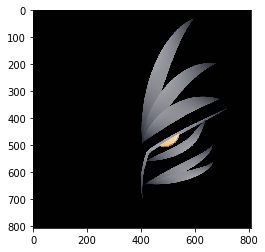

In [67]:
new_dataset = dataset.map(parse_function)
iterator = new_dataset.make_one_shot_iterator()
next_element = iterator.get_next()

sess = tf.InteractiveSession()

i = 1
while True:
    # 
    try:
        scalar,vector,matrix,tensor = sess.run([next_element['scalar'],
                                                next_element['vector'],
                                                next_element['matrix'],
                                                next_element['tensor']])
    except tf.errors.OutOfRangeError:
        print("End of dataset")
        break
    else:
        print('==============example %s ==============' %i)
        print('scalar: value: %s | shape: %s | type: %s' %(scalar, scalar.shape, scalar.dtype))
        print('vector shape: %s | type: %s' %(vector.shape, vector.dtype))
        print('matrix shape: %s | type: %s' %(matrix.shape, matrix.dtype))
        print('tensor shape: %s | type: %s' %(tensor.shape, tensor.dtype))
    i+=1
plt.imshow(tensor)

# shuffle

In [66]:
shuffle_dataset = new_dataset.shuffle(buffer_size=10000)
iterator = shuffle_dataset.make_one_shot_iterator()
next_element = iterator.get_next()

i = 1
while True:
    try:
        scalar = sess.run(next_element['scalar'])
    except tf.errors.OutOfRangeError:
        print("End of dataset")
        break
    else:
        print('example %s | scalar: value: %s' %(i,scalar))
    i+=1

example 1 | scalar: value: 1
example 2 | scalar: value: 3
example 3 | scalar: value: 2
example 4 | scalar: value: 3
example 5 | scalar: value: 2
example 6 | scalar: value: 1
End of dataset


# Batch

In [68]:
batch_dataset = shuffle_dataset.batch(4)
iterator = batch_dataset.make_one_shot_iterator()
next_element = iterator.get_next()

i = 1
while True:
    try:
        scalar = sess.run(next_element['scalar'])
    except tf.errors.OutOfRangeError:
        print("End of dataset")
        break
    else:
        print('example %s | scalar: value: %s' %(i,scalar))
    i+=1

example 1 | scalar: value: [1 3 1 2]
example 2 | scalar: value: [2 3]
End of dataset


# batch and padding

In [69]:
batch_padding_dataset = new_dataset.padded_batch(4, 
                        padded_shapes={'scalar': [],
                                       'vector': [-1,5],
                                       'matrix': [None,None],
                                       'matrix_shape': [None],
                                       'tensor': [None,None,None],
                                       'tensor_shape': [None]})
iterator = batch_padding_dataset.make_one_shot_iterator()
next_element = iterator.get_next()

i = 1
while True:
    try:
        scalar,vector,matrix,tensor = sess.run([next_element['scalar'],
                                                next_element['vector'],
                                                next_element['matrix'],
                                                next_element['tensor']])
    except tf.errors.OutOfRangeError:
        print("End of dataset")
        break
    else:
        print('==============example %s ==============' %i)
        print('scalar: value: %s | shape: %s | type: %s' %(scalar, scalar.shape, scalar.dtype))
        print('padded vector value\n%s:\nvector shape: %s | type: %s' %(vector, vector.shape, vector.dtype))
        print('matrix shape: %s | type: %s' %(matrix.shape, matrix.dtype))
        print('tensor shape: %s | type: %s' %(tensor.shape, tensor.dtype))
    i+=1

==============example 1 ==============
scalar: value: [1 2 3 1] | shape: (4,) | type: int64
padded vector value
[[[ 0.1  0.1  0.1  0.   0. ]]

 [[ 0.2  0.2  0.2  0.   0. ]]

 [[ 0.3  0.3  0.3  0.   0. ]]

 [[ 0.1  0.1  0.1  0.   0. ]]]:
vector shape: (4, 1, 5) | type: float32
matrix shape: (4, 2, 3) | type: float32
tensor shape: (4, 806, 806, 3) | type: uint8
==============example 2 ==============
scalar: value: [2 3] | shape: (2,) | type: int64
padded vector value
[[[ 0.2  0.2  0.2  0.   0. ]]

 [[ 0.3  0.3  0.3  0.   0. ]]]:
vector shape: (2, 1, 5) | type: float32
matrix shape: (2, 2, 3) | type: float32
tensor shape: (2, 806, 806, 3) | type: uint8
End of dataset


# epoch

In [70]:
num_epochs = 2
epoch_dataset = new_dataset.repeat(num_epochs)
iterator = epoch_dataset.make_one_shot_iterator()
next_element = iterator.get_next()

i = 1
while True:
    try:
        scalar = sess.run(next_element['scalar'])
    except tf.errors.OutOfRangeError:
        print("End of dataset")
        break
    else:
        print('example %s | scalar: value: %s' %(i,scalar))
    i+=1

example 1 | scalar: value: 1
example 2 | scalar: value: 2
example 3 | scalar: value: 3
example 4 | scalar: value: 1
example 5 | scalar: value: 2
example 6 | scalar: value: 3
example 7 | scalar: value: 1
example 8 | scalar: value: 2
example 9 | scalar: value: 3
example 10 | scalar: value: 1
example 11 | scalar: value: 2
example 12 | scalar: value: 3
End of dataset
